# Training Fast RCNN

## Imports and globals

In [1]:
import sys
import os
import _init_paths
import importlib
import shutil
import numpy as np
import tqdm

import torch
from torch.autograd import Variable
from utils.config import cfg
from pascalroidb import PascalRoiDB
from fastrcnnmodel import FastRCNNModel
from vgg import fast_rcnn_weights
from torch_utils import np_to_var, load_weights, save_weights
from train_utils import get_parameters, fast_rcnn_loss
from display_utils import display_image_regions
from data_utils import x1y1x2y2_to_xywh

from IPython.core.debugger import Tracer
from IPython.display import clear_output
%matplotlib inline

In [2]:
cfg.DATA_DIR = '../VOC/'

## Load Data

In [3]:
try:
    del train_set
    del train_loader
except:
    pass
devkit_path = os.path.join(cfg.DATA_DIR, 'VOCdevkit/')
train_set = PascalRoiDB(devkit_path, 'trainval', '2007', 
                        shuffle_samples=True)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=1, shuffle=False, num_workers=2)


No cache exists, loading from devkit
Appending horizontally-flipped training examples...
voc_2007_trainval ss roidb loaded from /home/slav/DL/VOC/cache/voc_2007_trainval_selective_search_roidb.pkl
done
Preparing training data...
done
Filtered 0 roidb entries: 10022 -> 10022
bbox target means:
[[ 0.          0.          0.          0.        ]
 [ 0.          0.00379662  0.02754976  0.06469912]
 [ 0.         -0.00138961  0.0633017   0.03448065]
 [ 0.          0.01547897  0.00778036  0.06749826]
 [ 0.         -0.00627642 -0.00140434  0.09385452]
 [ 0.         -0.00389383 -0.07596478  0.14041215]
 [ 0.          0.0029443  -0.01565004  0.09243322]
 [ 0.          0.0007864  -0.00063314  0.08758059]
 [ 0.          0.00526074  0.02774618  0.04674116]
 [ 0.          0.00073211 -0.01874643  0.07139775]
 [ 0.          0.00984952  0.00350275  0.06485032]
 [ 0.          0.01996824  0.08911847 -0.00315299]
 [ 0.          0.00077153  0.02670116  0.05070323]
 [ 0.          0.00817035 -0.00731261  0.05

## Fast RCNN after conv layers

In [4]:
try:
    del fast_rcnn_model
except NameError:
    pass

feats_weights, fc1_weights, fc2_weights = fast_rcnn_weights()

fast_rcnn_model = FastRCNNModel(feats_weights, fc1_weights, fc2_weights,
                                dropout_p=0.5).cuda()

##### Test the net

In [5]:

batch = next(train_loader.__iter__())
index, _, rois, targets, labels, preds_weights = [item[0] for item in batch]
image = batch[1]

image_var = Variable(image.cuda())
rois_var = Variable(rois.float().cuda())
out = fast_rcnn_model.forward(image_var, rois_var)
out[0].size(), out[1].size()

(torch.Size([64, 21]), torch.Size([64, 84]))

## Train loop

In [5]:
def train(net, dataset, loss_criterion, optimizer, 
          iterations=30000, print_every=10):
    net.train()
    total_loss = 0
    data_iterator = dataset.__iter__()
    t = tqdm.tqdm_notebook(total=iterations)
    current_iteration = 1
    while True:
        try:
            batch = next(data_iterator)
        except StopIteration:
            data_iterator = dataset.__iter__()
            batch = next(data_iterator)

        image = batch[1]
        (_, _, rois, targets, labels,
         preds_weights) = [item[0] for item in batch]

        images_var = Variable(image.cuda())
        rois_var = Variable(rois.float().cuda())

        targets_var = Variable(targets.cuda())
        labels_var = Variable(labels.cuda())
        preds_weights_var = Variable(preds_weights.cuda())
        
        # Clear Gradients
        optimizer.zero_grad()

        # Forward Pass
        output = net(images_var, rois_var)

        loss = loss_criterion(output, labels_var, targets_var, 
                             preds_weights_var)

        # Backprop
        loss.backward()
        optimizer.step()

        total_loss += loss.data[0]
        current_mean_loss = total_loss / current_iteration
        if (current_iteration + 1) % print_every == 0:
            clear_output()
            print(current_mean_loss, end=' ')

        current_iteration += 1
        if current_iteration > iterations:
            break
        t.update()
    t.close()
    mean_loss = total_loss / iterations
    return mean_loss


## Run the training

In [7]:
saved_path = 'intermediate/voc/weights-sgd-improved-310k.pth'
load_weights(fast_rcnn_model, saved_path)

In [6]:
# optimizer = torch.optim.Adam(params, lr=learning_rate)
learning_rate = 1e-3
params = get_parameters(fast_rcnn_model, learning_rate)
optimizer = torch.optim.SGD(params, lr=learning_rate, 
                            momentum=0.9, weight_decay=0.0005)
train(fast_rcnn_model, train_loader, fast_rcnn_loss, 
      optimizer, iterations=30000)

0.41474439836774013 


0.4147386253790309

In [7]:
learning_rate = 1e-4
params = get_parameters(fast_rcnn_model, learning_rate)
optimizer = torch.optim.SGD(params, lr=learning_rate, 
                            momentum=0.9, weight_decay=0.0005)
train(fast_rcnn_model, train_loader, fast_rcnn_loss, 
      optimizer, iterations=10000)

0.22111428620680088 


0.22112798368711956

In [8]:
saved_path = save_weights(fast_rcnn_model, 'intermediate/voc', 
                          'sgd-improved-40k')
saved_path

'intermediate/voc/weights-sgd-improved-40k.pth'

##### More training

In [10]:
learning_rate = 1e-5
params = get_parameters(fast_rcnn_model, learning_rate)
optimizer = torch.optim.SGD(params, lr=learning_rate, 
                            momentum=0.9, weight_decay=0.0005)
train(fast_rcnn_model, train_loader, fast_rcnn_loss, 
      optimizer, iterations=40000)

0.10168317765662374 


0.10168451584551767

In [9]:
learning_rate = 1e-6
params = get_parameters(fast_rcnn_model, learning_rate)
optimizer = torch.optim.SGD(params, lr=learning_rate, 
                            momentum=0.9, weight_decay=0.0005)
train(fast_rcnn_model, train_loader, fast_rcnn_loss, 
      optimizer, iterations=100000)

0.10944164420177763 

0.10944157725377852

## Test the net

In [5]:
iterator = train_loader.__iter__()

In [10]:
batch = next(iterator)
index, images, rois, targets = batch
index = index.cpu().numpy()[0]
images_var = Variable(images.cuda())
rois_var = Variable(rois[0].float().cuda())

out = fast_rcnn_model(images_var, rois_var)

tvmonitor
aeroplane
tvmonitor
boat
boat
boat
boat
boat
boat


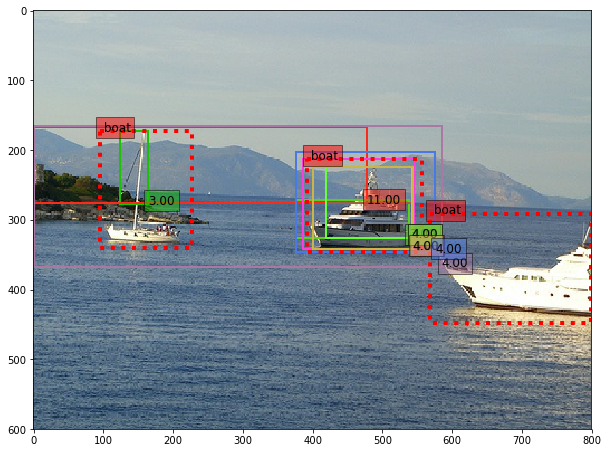

In [21]:
probas, indexes = torch.max(out[0], 1)
indexes_np = np.squeeze(indexes.data.cpu().numpy())
non_bg_rois_indexes = (indexes_np > 0)
'Total Detected: ', np.sum(non_bg_rois_indexes)

non_bg_rois = rois_var.data.cpu().numpy()[non_bg_rois_indexes]

detected_roi = np.append(non_bg_rois[:, 1:],
                         indexes_np[non_bg_rois_indexes][:, None],
                         axis=1)

detected_roi.shape

image = train_set._get_image(train_set.samples[index])
# image = PIL.Image.fromarray(image_arr.astype('uint8'))

for class_id in detected_roi[:, 4]:
    print(train_set.class_id_to_name[class_id])

# gt_boxes = train_set.samples[index]['gt_boxes_xywh']
    
display_image_regions(image, 
                      x1y1x2y2_to_xywh(detected_roi), 
                      # gt_boxes, 
                      class_id_to_name=train_set.imdb._ind_to_class)